# Système de Recherche de Documents Scientifiques

Ce projet vise à concevoir un moteur de recherche performant capable de classer des documents scientifiques en fonction de requêtes textuelles. Notre approche combine 3 méthodes:

1. **Similarité Lexicale** : Utilisation du TF-IDF (vecteurs creux) pour évaluer l'importance des termes dans les documents.
2. **Similarité Sémantique** : Utilisation d'embeddings (vecteurs denses) pour capturer le sens des documents.
3. **Analyse de Graphe** : Utilisation du Personalized PageRank (PPR) basé sur les citations pour valoriser la pertinence structurelle des documents.

In [1]:
from utils import load_corpus, load_queries, load_qrels

# Load the datasets
corpus = load_corpus('data/corpus.jsonl')
queries = load_queries('data/queries.jsonl')
qrels_valid = load_qrels('data/valid.tsv')


print(f"Loaded {len(corpus)} documents in corpus")
print(f"Loaded {len(queries)} queries")
print(f"Loaded relevance for {len(qrels_valid)} queries (dataset)")

Loaded 25657 documents in corpus
Loaded 1000 queries
Loaded relevance for 700 queries (dataset)


Dans cette première section, nous chargeons les trois composants essentiels de notre système :
- **Le Corpus** : Base de données contenant les textes et métadonnées des 25,657 documents scientifiques
- **Les Requêtes** : 1,000 énoncés de recherche des utilisateurs
- **Les Qrels (Query Relevance)** : Labels de pertinence pour 700 requêtes, utilisés pour valider nos modèles

Ces données constituent la fondation sur laquelle nous construirons et évaluerons nos différentes approches de recherche.

## Pre-traitement des Données

Nous fusionnons les titres et les résumés (textes) des documents pour créer une représentation textuelle complète. Cette étape permet d'extraire un maximum de signal pour nos futurs modèles de vectorisation.

In [2]:
from utils import preprocessing

text_corpus, text_queries = preprocessing(corpus, queries)

## 1. Approche Creuse (Bag of Words)

Avant de passer à des modèles complexes, nous établissons une première baseline en utilisant `CountVectorizer`. Cette méthode simple mais efficace à pour objectif de:

- Créer une représentation vectorielle de chaque document basée sur la fréquence des mots
- Visualiser les termes les plus fréquents dans le corpus
- Calculer une première mesure de similarité cosinus entre documents

La représentation Bag of Words est construite comme suit :
- Chaque document est représenté par un vecteur de dimension 78277 (vocabulaire total)
- Chaque dimension correspond à un mot unique
- La valeur dans chaque dimension indique le nombre d'occurrences de ce mot

Cette approche capture la présence et absence de termes mais ignore leur ordre et leur contexte sémantique.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
X_corpus = count_vectorizer.fit_transform(text_corpus.values())
X_queries = count_vectorizer.transform(text_queries.values())
X_corpus.shape, X_queries.shape

((25657, 78277), (1000, 78277))

### Visualisation des Termes les Plus Fréquents

Ce graphique révèle les mots-clés dominants dans notre corpus de documents scientifiques. L'analyse de ces termes nous permet de :
- Comprendre les thématiques principales du corpus
- Identifier les mots techniques récurrents
- Détecter d'éventuels biais dans la collection de documents

Les termes les plus fréquents sont typiquement des mots sans réel sens sémantique (et, ou, le, la) ainsi que des mots génériques (learning, network, algorithm) qui apparaissent dans de nombreux domaines de recherche.

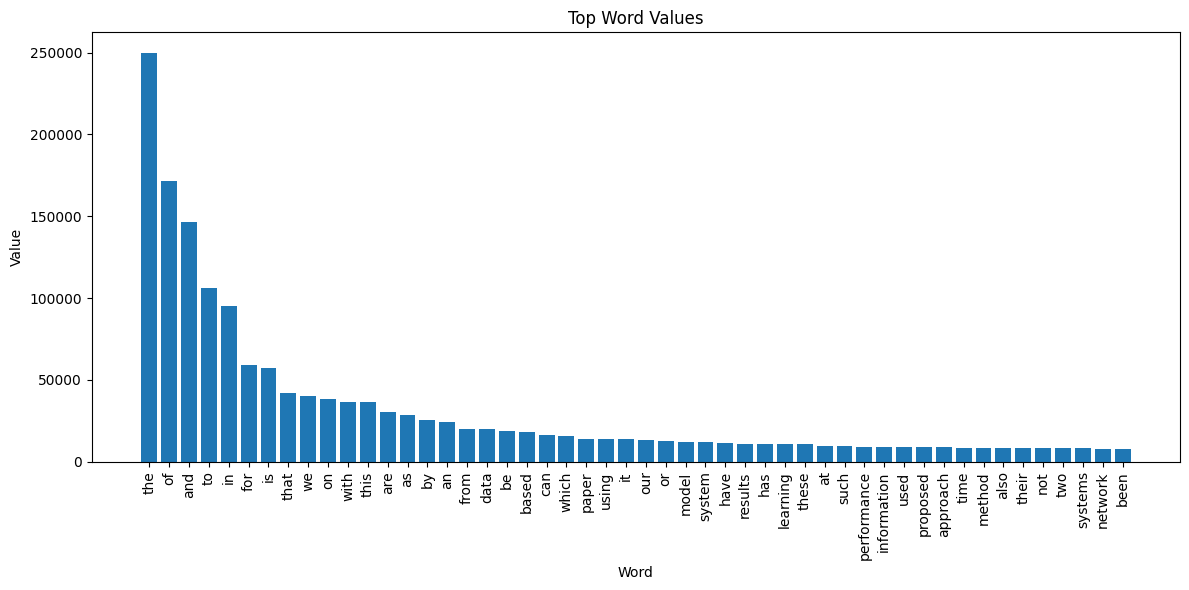

In [4]:
import matplotlib.pyplot as plt
from utils import print_feats

df = print_feats(X_corpus.sum(axis=0), count_vectorizer.get_feature_names_out(), top_n=50)
plt.figure(figsize=(12, 6))
plt.bar(df["word"], df["value"])
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Value")
plt.title("Top Word Values")
plt.tight_layout()
plt.show()

### Test de Similarité entre Documents

Cette cellule démontre le calcul de similarité cosinus entre deux documents choisis aléatoirement. 

**Interprétation** : 
- Un score de 46.4% indique une similarité modérée
- Les documents partagent probablement certains termes techniques mais traitent de sujets différents
- Cette méthode a des limites : elle ne capture pas les synonymes (ex: "voiture" vs "automobile")

In [5]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

ids = np.random.randint(0, X_corpus.shape[0]-1, size=2,)
similary = cosine_similarity(X_corpus[ids[0]], X_corpus[ids[1]])

print(f"Document 1:\n {list(text_corpus.values())[ids[0].item()]}")
print(f"Document 2:\n {list(text_corpus.values())[ids[1].item()]}")
print(f"similary: {similary.item()*100:.3f}%")

Document 1:
 The New Algorithms of Weighted Association Rules based on Apriori and FP-Growth Methods
In order to improve the frequent itemsets generated layer-wise efficiency, the paper uses the Apriori property to reduce the search space. FP-grow algorithm for mining frequent pattern steps mainly is divided into two steps: FP-tree and FP-tree to construct a recursive mining. Algorithm FP-Growth is to avoid the high cost of candidate itemsets generation, fewer, more efficient scanning. The paper puts forward the new algorithms of weighted association rules based on Apriori and FP-Growth methods. In the same support, this method is the most effective and stable maximum frequent itemsets mining capacity and minimum execution time. Through theoretical analysis and experimental simulation of the performance of the algorithm is discussed, it is proved that the algorithm is feasible and effective.
Document 2:
 An analytical framework for data stream mining techniques based on challenges and 

### Test du Moteur de Recherche Bag of Words

Cette cellule illustre le fonctionnement complet de notre premier moteur de recherche basé sur le Bag of Words. Pour une requête donnée :

1. La requête est vectorisée avec le même vocabulaire que le corpus
2. La similarité cosinus est calculée entre la requête et tous les documents
3. Les top-10 documents les plus similaires sont retournés avec leur score

- Limitation majeure : l'approche se base uniquement sur la correspondance lexicale exacte

In [6]:
import random
from browsers import sparse_browser
from utils import show_results

random_id = random.choice(list(text_queries.keys()))
text_query = {random_id: text_queries[random_id]}

print(f"Query:\n {text_query[random_id]}\n")

results = sparse_browser(text_query, text_corpus, count_vectorizer, top_k=10)

show_results(results, corpus)

Query:
 2011 Senior Thesis Project Reports Place Recognition for Indoor Blind Navigation Contents

Score |                      Title                         
-----------------------------------------------------------
25.82% | Blind Signatures for Untraceable Payments
24.14% | A UWB based Localization System for Indoor Robot Navigation
23.45% | Visual Place Recognition: A Survey
21.82% | Topological pattern recognition for point cloud data ∗
21.26% | ICDAR 2013 Chinese Handwriting Recognition Competition
20.73% | Speech recognition of Malayalam numbers
20.33% | Gujarati Script Recognition : A Review
19.96% | RFID in robot-assisted indoor navigation for the visually impaired
19.73% | A novel objective function for improved phoneme recognition using time delay neural networks
19.64% | Vision for Mobile Robot Navigation: A Survey
-----------------------------------------------------------


### Évaluation sur l'ensemble de validation

In [7]:
from browsers import valid_browser
from utils import display_metrics

metrics = valid_browser(
    sparse_browser, 
    qrels_valid,
    text_queries,
    text_corpus,
    count_vectorizer,
)

display_metrics(metrics)

  0%|          | 0/700 [00:00<?, ?it/s]

Metric,Score
Precision,0.263
Recall,0.604
F1-score,0.366
AUROC,0.635


## 2. Approche Dense (Embeddings Sémantiques)

Les embeddings transforment radicalement notre approche en capturant le **sens** plutôt que juste les mots.

On utilise le model `all-MiniLM-L6-v2`, qui offre plusieurs avantages clés :
- Modèle pré-entraîné de la bibliothèque SentenceTransformers
- Transforme chaque texte en un vecteur dense de 384 dimensions
- Entraîné sur des millions de paires de phrases pour capturer la similarité sémantique

### Avantages par rapport au Bag of Words :
1. **Synonymes** : "véhicule" et "automobile" auront des représentations proches
2. **Contexte** : Même sans mots communs, deux textes sur le même sujet seront similaires
3. **Compacité** : 384 dimensions vs 78,277 pour le BoW

Les embeddings ont été pré-calculés et sauvegardés pour gagner du temps. Décommenter les lignes de `save_embeddings` pour les régénérer.

In [8]:
import torch
from sentence_transformers import SentenceTransformer
from utils import save_embeddings, load_embeddings

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using device: {device}")
encoder = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# Remove comments to re-generate embeddings
# save_embeddings(encoder, text_corpus, 'data/corpus_embeddings.npz', device=device)
# save_embeddings(encoder, text_queries, 'data/queries_embeddings.npz', device=device)

corpus_embeddings = load_embeddings('data/corpus_embeddings.npz')
queries_embeddings = load_embeddings('data/queries_embeddings.npz')

Using device: mps


### Test du Moteur de Recherche Sémantique

Cette cellule illustre le fonctionnement complet de notre moteur de recherche basé sur les embeddings sémantiques. Pour une requête donnée :
- Le document le plus pertinent atteint désormais 53.80% de similarité (vs 25.82% avec BoW)
- Les résultats sont plus cohérents thématiquement
- Le modèle capture des relations sémantiques que l'approche lexicale manquait

Même sans correspondance exacte de mots, la similarité sémantique fonctionne

In [9]:
import random
from browsers import dense_browser
from utils import show_results

query_id = random.sample(list(queries_embeddings.keys()), 1)[0]
query_embedding = {query_id: queries_embeddings[query_id]}

print(f"Query:\n {text_queries[query_id]}\n")

results = dense_browser(query_embedding, corpus_embeddings, encoder, top_k=10)

show_results(results, corpus)

Query:
 Data-Driven Networking : Harnessing the “ Unreasonable Effectiveness of Data ” in Network Design

Score |                      Title                         
-----------------------------------------------------------
53.80% | A clean slate 4D approach to network control and management
53.37% | A case for stateful forwarding plane
51.77% | Named data networking
49.98% | A data-oriented (and beyond) network architecture
48.81% | AVANT-GUARD: scalable and vigilant switch flow management in software-defined networks
48.53% | DoS & DDoS in Named Data Networking
47.90% | DoS and DDoS in Named Data Networking
47.69% | Achieving high utilization with software-driven WAN
47.54% | Denial of Service in Sensor Networks
46.82% | Xpander: Towards Optimal-Performance Datacenters
-----------------------------------------------------------


### Évaluation sur l'Ensemble de Validation

- Le doublement des performances sur les métriques valident l'approche sémantique comme nettement supérieure par rapport au Bag of Words.

In [10]:
from browsers import valid_browser
from utils import display_metrics

metrics = valid_browser(
    dense_browser, 
    qrels_valid,
    queries_embeddings,
    corpus_embeddings,
    encoder,
)

display_metrics(metrics)

  0%|          | 0/700 [00:00<?, ?it/s]

Metric,Score
Precision,0.650
Recall,0.868
F1-score,0.743
AUROC,0.888


## 3. Analyse de Structure avec Personalized PageRank (PPR)

La pertinence d'un document ne dépend pas seulement de son texte, mais aussi de sa place dans le réseau scientifique. Un article scientifique n'existe pas en isolation. Sa valeur dépend aussi de :
- Combien de fois il est cité (popularité)
- Par qui il est cité (autorité)
- Sa position dans le réseau de citations

Nous construisons un graphe orienté où chaque arête représente une citation. L'algorithme PageRank Personnalisé nous permet de calculer un score d'autorité pour chaque document, centré spécifiquement sur le contexte de la requête. Contrairement au PageRank classique qui est global, le PPR :
1. Part d'un ensemble de documents sources
2. Propage l'autorité dans le graphe selon les citations
3. Donne plus de poids aux documents proches des sources

Cela permet d'identifier des documents pertinents qui pourraient ne pas avoir de similarité textuelle directe mais qui sont structurellement importants dans le domaine de la requête.

In [11]:
from graph import build_citation_graph

G = build_citation_graph(queries, corpus)
print("Nombre de documents:", G.number_of_nodes())
print("Nombre de liens de citation:", G.number_of_edges())

Nombre de documents: 26657
Nombre de liens de citation: 24637


### Documents les Plus Cités

Cette analyse révèle les "piliers" de notre corpus scientifique. Ces articles hautement cités sont souvent des méthodes fondamentales, citées dans de nombreux travaux de recherche. Ils constituent la "base de connaissances" du domaine.

Si une requête concerne un sujet lié à ces travaux fondateurs, donner plus de poids à ces documents dans les résultats peut améliorer la pertinence.

In [12]:
from utils import show_citations

results = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:10]

show_citations(results, queries, corpus)

Citations |                  Title                         
-----------------------------------------------------------
   182    | Adam: A Method for Stochastic Optimization
   175    | Deep Residual Learning for Image Recognition
   167    | Very Deep Convolutional Networks for Large-Scale Image Recognition
   162    | Long Short-Term Memory
   133    | Gradient-based learning applied to document recognition
   117    | Latent Dirichlet Allocation
   113    | No Title
   110    | Going deeper with convolutions
   107    | Glove: Global Vectors for Word Representation
   106    | Caffe: Convolutional Architecture for Fast Feature Embedding
-----------------------------------------------------------


## 4. Évaluation d'un Modèle Hybride

Nous implémentons un classifieur hybride qui combine les scores de similarité textuelle et les scores PPR. L'objectif est d'optimiser les paramètres suivants sur notre jeu de validation :
- Alpha ($\alpha$) : Facteur d’amortissement de l’algorithme PageRank.
- Beta ($\beta$) : Équilibre entre le texte et le graphe.
- Temperature ($T$) : Ajustement de la distribution de probabilité (Softmax).

**Score Final = (1-β) × Score_Sémantique + β × Score_PPR**

In [ ]:
import random
from graph import get_all_ppr
from browsers import dense_browser
from utils import show_results

alpha = 0.9
beta = 0.99
temperature = 3.0

query_id = random.sample(list(queries_embeddings.keys()), 1)[0]
query_embedding = {query_id: queries_embeddings[query_id]}

ppr_dict = get_all_ppr(G, [query_id], alpha=alpha)

print(f"Query:\n {text_queries[query_id]}\n")

results = dense_browser(
    query_embedding,
    corpus_embeddings,
    encoder,
    ppr=ppr_dict[query_id],
    beta=beta,
    temperature=temperature,
    top_k=10,
)

show_results(results, corpus, use_graphs=True)

  0%|          | 0/1 [00:00<?, ?it/s]

Query:
 Computation offloading for mobile edge computing: A deep learning approach

Score |                      Title                         
-----------------------------------------------------------
40.1910e-5 | Adam: A Method for Stochastic Optimization
39.9010e-5 | Offloading in Mobile Cloudlet Systems with Intermittent Connectivity
39.9010e-5 | Energy-Efficient Resource Allocation for Mobile-Edge Computation Offloading
39.8410e-5 | Dynamic Computation Offloading for Mobile-Edge Computing With Energy Harvesting Devices
39.8410e-5 | Multi-Label Classification: An Overview
39.6810e-5 | Dynamic Programming and Optimal Control
39.3810e-5 | A Framework for Multiple-Instance Learning
39.3610e-5 | RCV1: A New Benchmark Collection for Text Categorization Research
39.3610e-5 | An overview of gradient descent optimization algorithms
39.3610e-5 | On the momentum term in gradient descent learning algorithms
-----------------------------------------------------------


In [14]:
from graph import get_all_ppr
from browsers import valid_browser
from utils import display_metrics

# Generate PPR for validation queries
val_ids = list(qrels_valid.keys())
ppr_dict_val = get_all_ppr(G, val_ids, alpha=alpha)

metrics = valid_browser(
    dense_browser, 
    qrels_valid,
    queries_embeddings,
    corpus_embeddings,
    encoder,
    ppr_dict=ppr_dict_val,
    beta=beta,
    temperature=temperature,
)

display_metrics(metrics)

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Metric,Score
Precision,0.761
Recall,0.906
F1-score,0.827
AUROC,0.925


  0%|          | 0/700 [00:00<?, ?it/s]

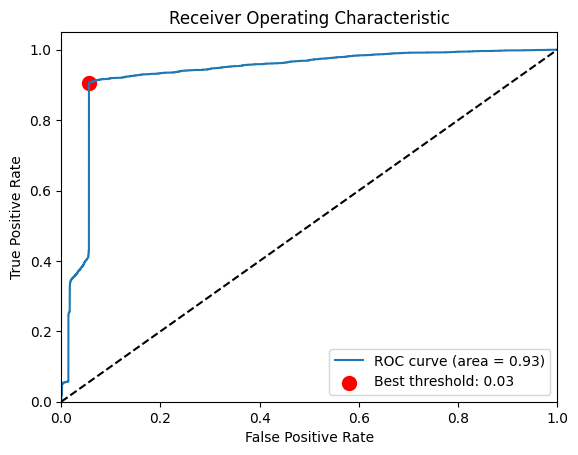

Best threshold: 0.0333


In [15]:
from browsers import get_logits
from utils import plot_auroc

y_pred, y_true = get_logits(
    dense_browser, 
    qrels_valid,
    queries_embeddings,
    corpus_embeddings,
    encoder,
    ppr_dict=ppr_dict_val,
    beta=beta,
    temperature=temperature,
)

best_threshold = plot_auroc(y_true=y_true, y_pred=y_pred)
print(f"Best threshold: {best_threshold:.4f}")

## Prédiction sur le jeu de test

On applique le modèle hybride optimisé sur le jeu de test final pour générer les résultats finaux.

In [16]:
import os
from browsers import predict_browser
from utils import load_test, save_predictions

alpha = 0.9
beta = 0.99
temperature = 3.0

test_queries = load_test('data/test_final.tsv')

# Generate PPR for test queries
test_ids = list(test_queries.keys())
ppr_dict_test = get_all_ppr(G, test_ids, alpha=alpha)

preds = predict_browser(
    dense_browser,
    test_queries,
    queries_embeddings,
    corpus_embeddings,
    encoder,
    best_threshold,
    ppr_dict_test,
    beta=beta,
    temperature=temperature,
)

os.makedirs('results', exist_ok=True)
save_predictions(preds, test_queries, 'results/test_predictions.csv')

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]